## Auteurs : Azdad Bilal; Ourkia Abdelhakim; Sarhane Abdelmouhaimen

# Chargement des données !

Dans notre projet **Classification des panneaux routiers**, nous avons choisi de classifier des images associées à 5 labels différents : **stop**, **crosswalk** , **speedlimit**, **trafficlight**, **no-entry**.



Nous avons réparti nos images dans 3 ensembles (et donc 3 dossiers): *train* (entre 142 et 156 images par classe), *validation* (31 image par classe) et *test* (31 image par classe). Chacun de ces dossiers comporte un sous-dossier par classe, qui contient les images correspondantes.

Nous avons choisi d'héberger notre base de données sur Github : l'intérêt est qu'un **git clone** depuis Google Colab est très rapide, ce qui vous garantit une certaine simplicité. Je vous encourage à en faire de même.

In [10]:
!git clone https://github.com/bilales/AI_projects.git
path = "AI_projects/TrafficSignsClassification_DL/data/"


fatal: destination path 'AI_projects' already exists and is not an empty directory.


Une fois les données téléchargées localement, on peut maintenant charger les images et les labels.

In [11]:
import os
import shutil

import numpy as np
import PIL
from PIL import Image
import os, sys
from scipy.io import loadmat


def load_data(data_path, classes, dataset='train', image_size=64):

    num_images = 0
    for i in range(len(classes)):
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[i]))
        num_images += len(dirs)

    x = np.zeros((num_images, image_size, image_size, 3))
    y = np.zeros((num_images, 1))

    current_index = 0

    # Parcours des différents répertoires pour collecter les images
    for idx_class in range(len(classes)):
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[idx_class]))
        num_images += len(dirs)

        # Chargement des images,
        for idx_img in range(len(dirs)):
            item = dirs[idx_img]
            if os.path.isfile(data_path + dataset + '/' + classes[idx_class] + '/' + item):
                # Ouverture de l'image
                img = Image.open(data_path + dataset + '/' + classes[idx_class] + '/' + item)
                # Conversion de l'image en RGB
                img = img.convert('RGB')
                # Redimensionnement de l'image et écriture dans la variable de retour x
                img = img.resize((image_size,image_size))
                x[current_index] = np.asarray(img)
                # Écriture du label associé dans la variable de retour y
                y[current_index] = idx_class
                current_index += 1

    return x, y

Voici ensuite un exemple de chargement de vos données. Notez que vous pouvez modifier la dimension des images, ce qui sera utile à différents stades de votre projet.

In [12]:
labels = ['crosswalk', 'no-entry', 'speedlimit','stop','trafficlight']

x_train, y_train = load_data(path, labels, dataset='train', image_size=64)
print(x_train.shape, y_train.shape)

x_val, y_val = load_data(path, labels, dataset='validation', image_size=64)
print(x_val.shape, y_val.shape)

x_test, y_test = load_data(path, labels, dataset='test', image_size=64)
print(x_test.shape, y_test.shape)

(742, 64, 64, 3) (742, 1)
(154, 64, 64, 3) (154, 1)
(155, 64, 64, 3) (155, 1)


Vous pouvez utiliser le bloc suivant pour afficher quelques-unes de vos images, et ainsi vérifier que tout s'est bien passé.

<ipython-input-13-0d6ab2e86325>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(labels[int(y_train[shuffle_indices[i]])])


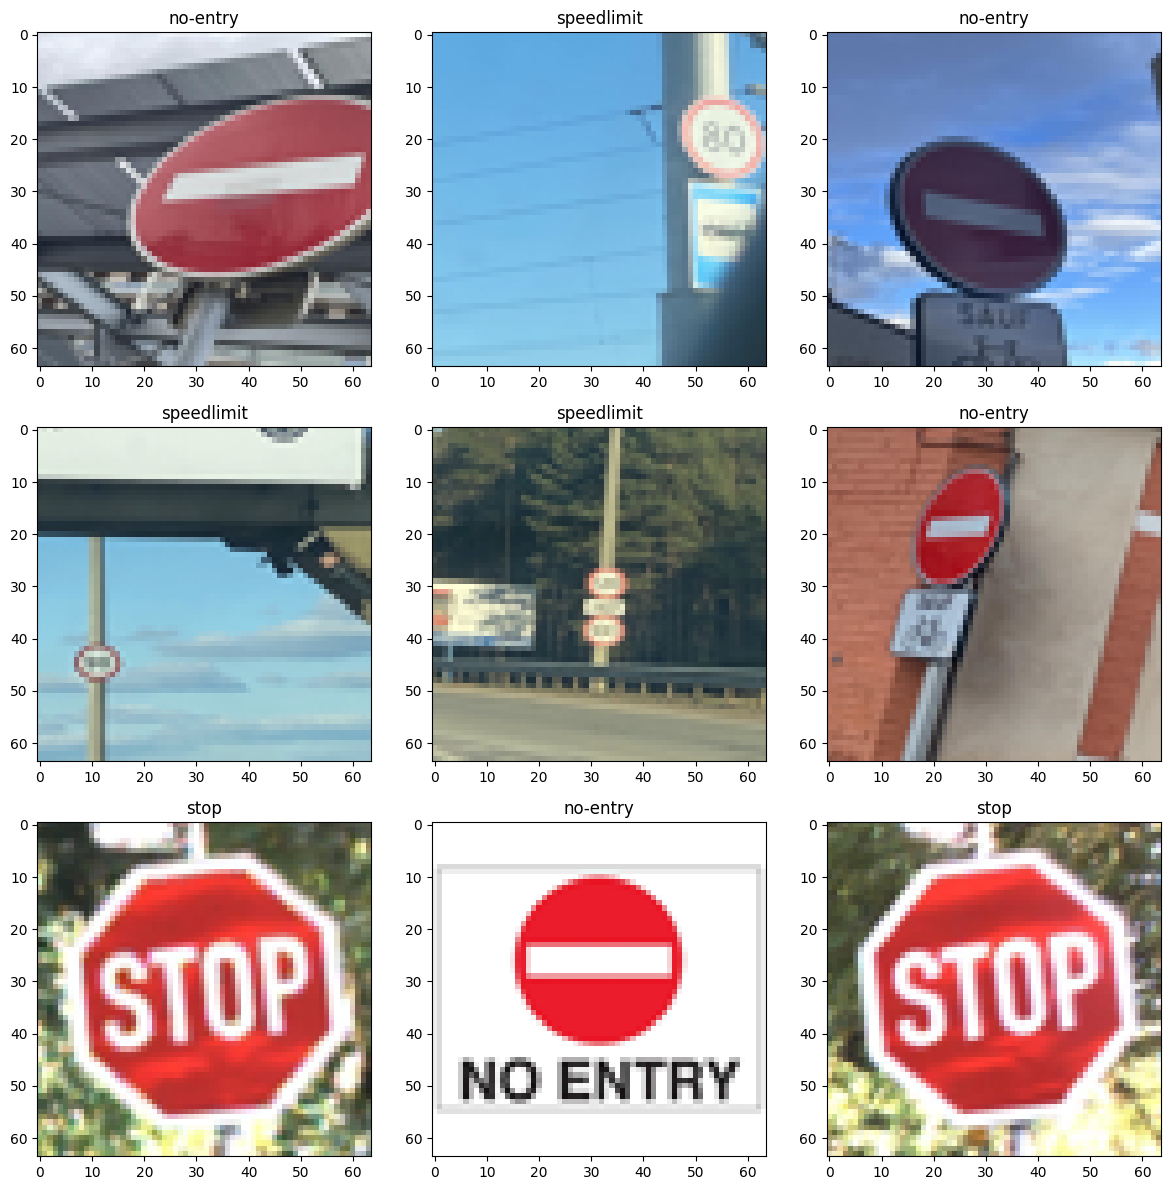

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
shuffle_indices = np.random.permutation(500)
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    image = x_train[shuffle_indices[i]]
    plt.title(labels[int(y_train[shuffle_indices[i]])])
    plt.imshow(image/255)

plt.tight_layout()
plt.show()

# Création du modèle  !

## Modèle CNN pour la Classification d'Images

Notre modèle est une architecture de réseau de neurones convolutif conçue pour classer des images en couleurs de 64x64 pixels en 5 catégories différentes. Le cœur de ce modèle réside dans son habileté à extraire et à apprendre des caractéristiques visuelles importantes grâce à une série de couches spécialisées.

### Structure du Modèle :

- **Départ avec une Couche d'Entrée** : Traitement d'images RGB de taille 64x64.

- **Couches Convolutionnelles et Pooling** :
  - Quatre ensembles de couches convolutionnelles suivies de pooling réduisent la dimension tout en captant les détails essentiels.
  - Les filtres augmentent de 32 à 128 à travers les couches, permettant une extraction de caractéristiques de plus en plus fine.

- **Aplatissement et Classification** :
  - Les caractéristiques sont ensuite aplatis en un vecteur et passent par une couche dense de 512 neurones avec ReLU.
  - La dernière étape est une couche de sortie avec activation softmax pour la classification en 5 classes.

### Compilation :

- **Optimiseur** : Adam, pour une descente de gradient efficace.
- **Perte** : Entropie croisée catégorique sparse, parfaite pour des labels de classe entiers.
- **Métrique** : Précision, pour évaluer la performance du modèle.

Ce modèle tire parti des CNN pour une extraction efficace des caractéristiques et une classification précise, le rendant idéal pour des tâches de vision par ordinateur complexes.




In [14]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten,Input

In [15]:
def creat_model (IMAGE_SIZE = 64) :

    model = Sequential()

    model.add(Input((IMAGE_SIZE,IMAGE_SIZE,3)))
    model.add(Conv2D(32,(3,3),padding ="valid" , activation = "ReLU"))

    model.add(MaxPooling2D((2,2)))

    model.add(Conv2D(64,(3,3),padding ="valid", activation = "ReLU"))

    model.add(MaxPooling2D((2,2)))

    model.add(Conv2D(96,(3,3),padding ="valid", activation = "ReLU"))

    model.add(MaxPooling2D((2,2)))

    model.add(Conv2D(128,(3,3),padding ="valid", activation = "ReLU"))

    model.add(MaxPooling2D((2,2)))

   # model.add(Conv2D(256,(3,3),padding ="same", activation = "ReLU"))

    #model.add(MaxPooling2D((2,2)))


    #model.add(Conv2D(128,(3,3),padding ="same", activation = "ReLU"))

    #model.add(MaxPooling2D((2,2)))
    # ...

    model.add(Flatten())
    model.add(Dense(512,activation = "ReLU"))

    #model.add(Dense(512,activation = "ReLU"))

    #model.add(Dense(128,activation = "ReLU"))

    model.add(Dense(5, activation='softmax'))




    # Compiler le modèle
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',  # Perte de l'entropie croisée
                  metrics=['accuracy'])  # Métrique de précision

    return model

In [16]:


def plot_training_analysis(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()


In [17]:

model = creat_model ()
model.summary()
x_train = x_train/255
x_val = x_val/255
x_test = x_test/255

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 96)          0

# Entraînement !

In [18]:
history = model.fit(x_train,y_train,validation_data=(x_val, y_val), epochs=20)

Epoch 1/20
24/24 [==============================] - 6s 44ms/step - loss: 1.4440 - accuracy: 0.3073 - val_loss: 1.2265 - val_accuracy: 0.4286
Epoch 2/20
24/24 [==============================] - 0s 12ms/step - loss: 1.1442 - accuracy: 0.4973 - val_loss: 1.1043 - val_accuracy: 0.5779
Epoch 3/20
24/24 [==============================] - 0s 9ms/step - loss: 0.9785 - accuracy: 0.6011 - val_loss: 0.9810 - val_accuracy: 0.5844
Epoch 4/20
24/24 [==============================] - 0s 11ms/step - loss: 0.9545 - accuracy: 0.6105 - val_loss: 0.9844 - val_accuracy: 0.5455
Epoch 5/20
24/24 [==============================] - 0s 10ms/step - loss: 0.8558 - accuracy: 0.6550 - val_loss: 0.8047 - val_accuracy: 0.7338
Epoch 6/20
24/24 [==============================] - 0s 10ms/step - loss: 0.7442 - accuracy: 0.7210 - val_loss: 0.7321 - val_accuracy: 0.6948
Epoch 7/20
24/24 [==============================] - 0s 12ms/step - loss: 0.6747 - accuracy: 0.7520 - val_loss: 0.6622 - val_accuracy: 0.7468
Epoch 8/20
24/

###Bien qu'on obtienne un résultat satisfaisant, on observe un sur-apprentissage que l'on va pallier en ajoutant artificiellement de la data

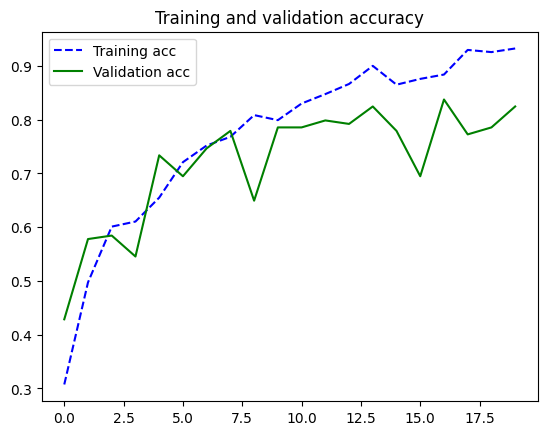

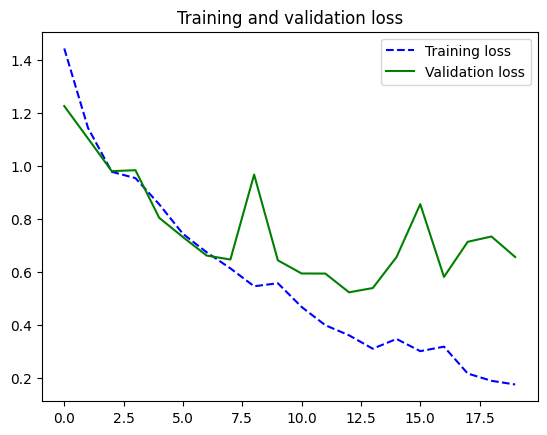

In [19]:
plot_training_analysis(history)

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

<ipython-input-21-da784e1609a0>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(labels[int(example_y[i])])


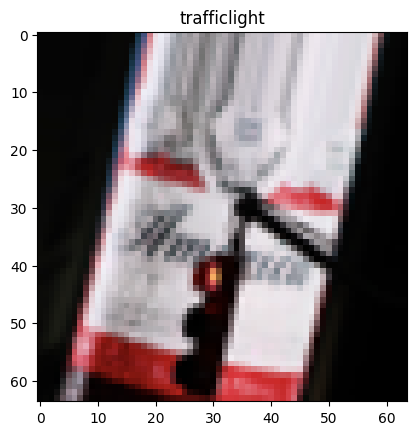

In [21]:
example_x, example_y = train_datagen.flow(x_train, y_train, batch_size=1).next()
example_x.shape
for i in range(0,1):
    plt.imshow(example_x[i])
    plt.title(labels[int(example_y[i])])
    plt.show()


In [22]:
history = model.fit(train_datagen.flow(x_train, y_train, batch_size=10),validation_data=(x_val, y_val), epochs=20)

Epoch 1/20
75/75 [==============================] - 2s 19ms/step - loss: 1.0235 - accuracy: 0.6105 - val_loss: 0.8386 - val_accuracy: 0.6688
Epoch 2/20
75/75 [==============================] - 2s 22ms/step - loss: 0.9082 - accuracy: 0.6456 - val_loss: 0.6427 - val_accuracy: 0.7662
Epoch 3/20
75/75 [==============================] - 1s 15ms/step - loss: 0.7170 - accuracy: 0.7237 - val_loss: 0.5661 - val_accuracy: 0.8052
Epoch 4/20
75/75 [==============================] - 1s 14ms/step - loss: 0.7459 - accuracy: 0.7062 - val_loss: 0.6289 - val_accuracy: 0.7987
Epoch 5/20
75/75 [==============================] - 1s 15ms/step - loss: 0.6823 - accuracy: 0.7534 - val_loss: 0.5246 - val_accuracy: 0.8182
Epoch 6/20
75/75 [==============================] - 1s 15ms/step - loss: 0.6436 - accuracy: 0.7668 - val_loss: 0.5949 - val_accuracy: 0.8117
Epoch 7/20
75/75 [==============================] - 1s 15ms/step - loss: 0.6119 - accuracy: 0.7695 - val_loss: 0.6532 - val_accuracy: 0.7987
Epoch 8/20
75

###On observe de meilleurs résultats bien que des difficultés restent à résoudre, on peut encore améliorer notre algortihme en implantémentant d'autres techniques comme le fine tuning et le transfert learning, ceci arrive bientôt !

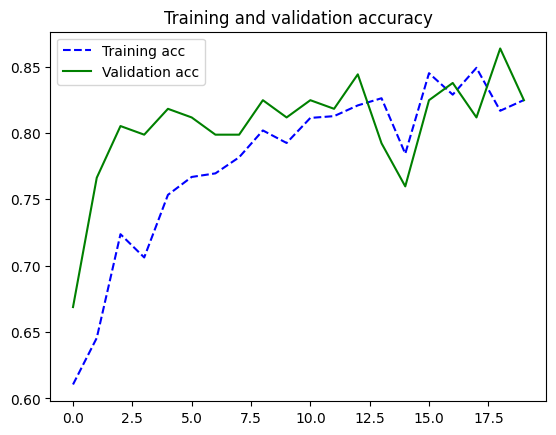

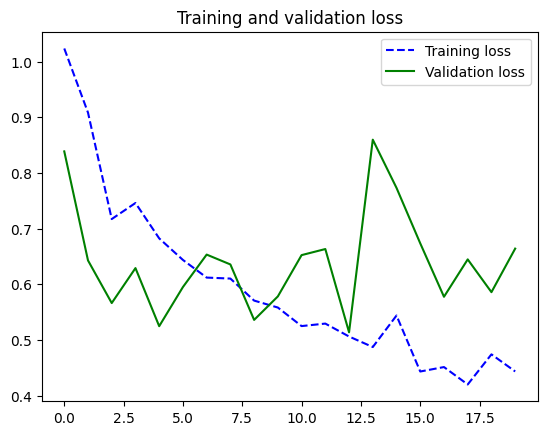

In [24]:
plot_training_analysis(history)